In [2]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

#Read Data

In [4]:
df=pd.read_csv('/content/MaunaLoaDailyTemps.csv',index_col='DATE',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (1821, 5)


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


#Plot Your Data

<Axes: xlabel='DATE'>

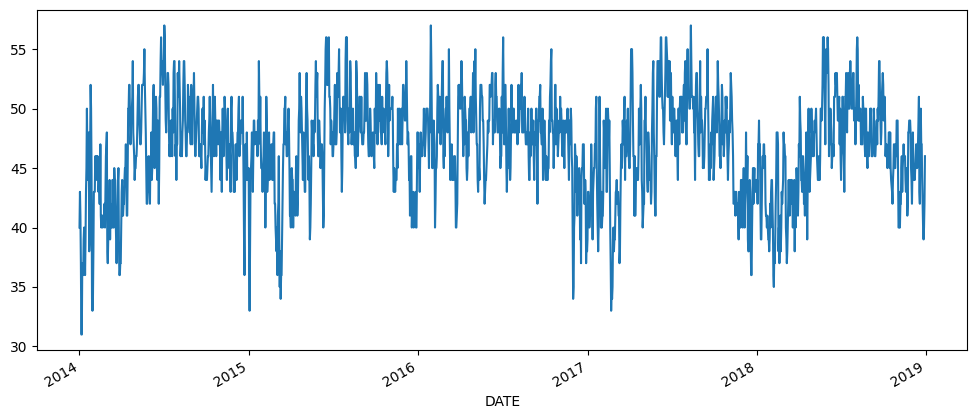

In [5]:
df['AvgTemp'].plot(figsize=(12,5))

#Check For Stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

You don’t need to worry about all the complex statistics. To interpret the test results, you only need to look at the p value. And you use the following simple method:

If p< 0.05 ; Data is stationary

if p>0.05; Data is not stationary

It’s not a hard and fast rule, but a stationary data should have a small p value. Larger p value could indicate presence of certain trends(varying mean) or seasonality as well.

In [7]:
adf_test(df['AvgTemp'])

1. ADF :  -6.554680125068777
2. P-Value :  8.675937480199653e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


#Figure Out Order for ARIMA Model

In [8]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

ARIMA is composed of 3 terms(Auto-Regression + Integrated+Moving-Average)

    
1. Auto-Regression:

This basically means that you are using the previous values of the time series in order to predict the future. How many past values you use, determine the order of the AR model. Here’s how an AR(1) model looks like:

Y(t)= Some_Constant*Y(t-1)+ Another_Constant +Error(t)

2. Integrated:

So, remember our talk on stationarity, and how it’s extremely important? Well if you'r data set is not stationary, you most often need to perform some sort of difference operation to make it stationary. If you are differencing with previous value, its order 1 and so on.
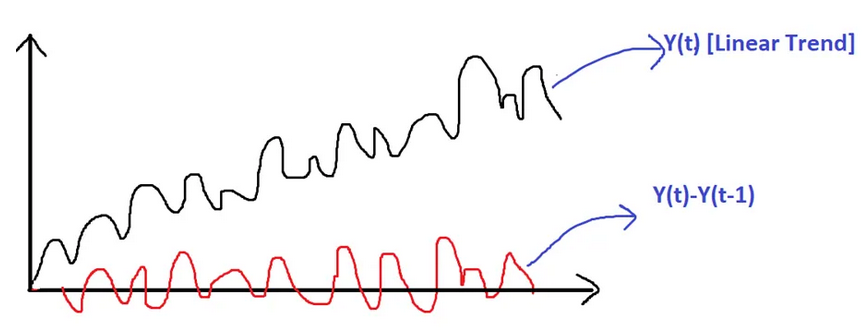

3. Moving Average:

This basically means that you are using previous errors to make the future prediction. Also makes sense, right? By seeing how wrong you were in your prediction, you take that into account to make a better prediction. And just like in an AR model, the number of previous errors(also called number of lags) you use, determines the order of the model.

Here’s how MA(1) order equation looks like:
Y(t)= Mean + Some_Constant*Error(t-1) +Error(t)

So our main job is to decide the order of the AR, I, MA parts which are donated by(p,d,q) respectively.

And before you start worrying, let me tell everything is gonna be done automatically. pmdarima library comes to our rescue! It does the job of figuring out the order of the ARIMA all by itself. Here’s how the code snippet looks like

In [9]:
stepwise_fit = auto_arima(df['AvgTemp'],
                          suppress_warnings=True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.517
Date:                Wed, 08 Jan 2025   AIC                           8295.034
Time:                        09:53:24   BIC                           8339.092
Sample:                             0   HQIC                          8311.288
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2070      0.362      3.335      0.001       0.498       1.916
ar.L1          0.9739      0.008    124.621      0.000       0.959       0.989
ma.L1         -0.1246      0.024     -5.256      0.000      -0.171      -0.078
ma.L2         -0.2196      0.024     -9.115      0.000      -0.267      -0.172
ma.L3         -0.2056      0.024     -8.615      0.000      -0.252      -0.159
ma.L4         -0.1373      0.023     -6.034      0.000      -0.182      -0.093
ma.L5         -0.0476      0.024     -1.952      0.051      -0.095       0.000
sigma2         5.4981      0.172     31.952      0.000       5.161       5.835
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.20
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.17
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 We simple supply our data to the auto_arima function. The function basically uses something called as the AIC score to judge how good a particular order model is. It simply tries to minimize the AIC score

In [11]:
from statsmodels.tsa.arima_model import ARIMA

#Split Data into Training and Testing

In [12]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(1821, 5)
(1791, 5) (30, 5)
MinTemp      36.0
MaxTemp      52.0
AvgTemp      44.0
Sunrise     640.0
Sunset     1743.0
Name: 2018-12-01 00:00:00, dtype: float64 MinTemp      39.0
MaxTemp      52.0
AvgTemp      46.0
Sunrise     656.0
Sunset     1754.0
Name: 2018-12-30 00:00:00, dtype: float64


## Train the Model

In [14]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['AvgTemp'],order=(1,0,5))
model=model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Wed, 08 Jan 2025   AIC                           8156.395
Time:                        10:10:10   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Make Predictions on Test Set

<Axes: xlabel='DATE'>

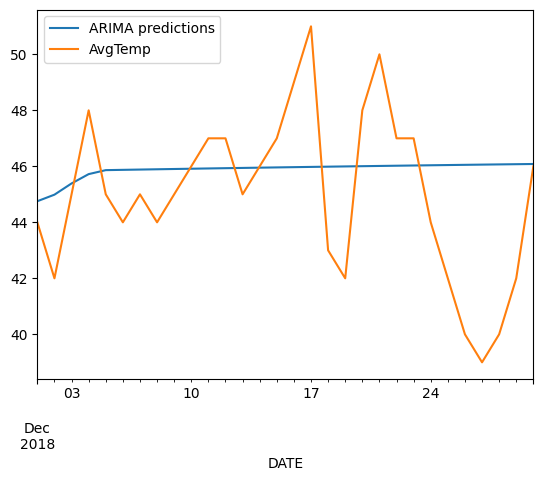

In [16]:
start=len(train)
end=len(train)+len(test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.index=index_future_dates
pred.plot(legend=True)
test['AvgTemp'].plot(legend=True)


<Axes: xlabel='DATE'>

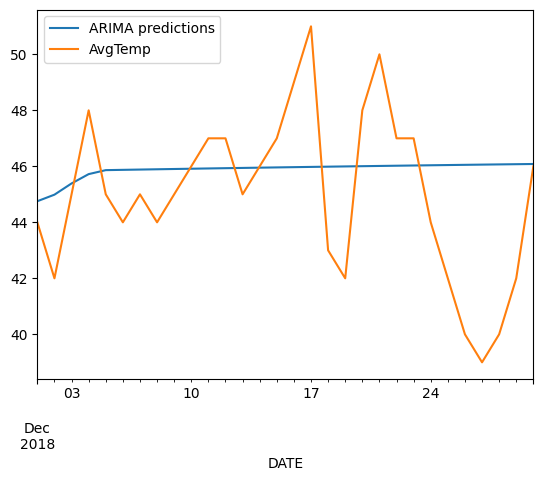

In [17]:
pred.plot(legend='ARIMA Predictions')
test['AvgTemp'].plot(legend=True)

In [18]:
test['AvgTemp'].mean()

45.0

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['AvgTemp']))
print(rmse)


3.000463825206671


In [20]:
model2=ARIMA(df['AvgTemp'],order=(1,0,5))
model2=model2.fit()
df.tail()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753
2018-12-29,36.0,47.0,42.0,655,1753
2018-12-30,39.0,52.0,46.0,656,1754


#For Future Dates

In [21]:
index_future_dates=pd.date_range(start='2018-12-30',end='2019-01-29')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2018-12-30    46.418166
2018-12-31    46.113912
2019-01-01    45.617874
2019-01-02    45.249566
2019-01-03    45.116916
2019-01-04    45.136666
2019-01-05    45.156140
2019-01-06    45.175341
2019-01-07    45.194274
2019-01-08    45.212942
2019-01-09    45.231349
2019-01-10    45.249498
2019-01-11    45.267394
2019-01-12    45.285038
2019-01-13    45.302436
2019-01-14    45.319591
2019-01-15    45.336505
2019-01-16    45.353183
2019-01-17    45.369628
2019-01-18    45.385842
2019-01-19    45.401830
2019-01-20    45.417593
2019-01-21    45.433137
2019-01-22    45.448462
2019-01-23    45.463574
2019-01-24    45.478474
2019-01-25    45.493165
2019-01-26    45.507651
2019-01-27    45.521934
2019-01-28    45.536017
2019-01-29    45.549904
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: >

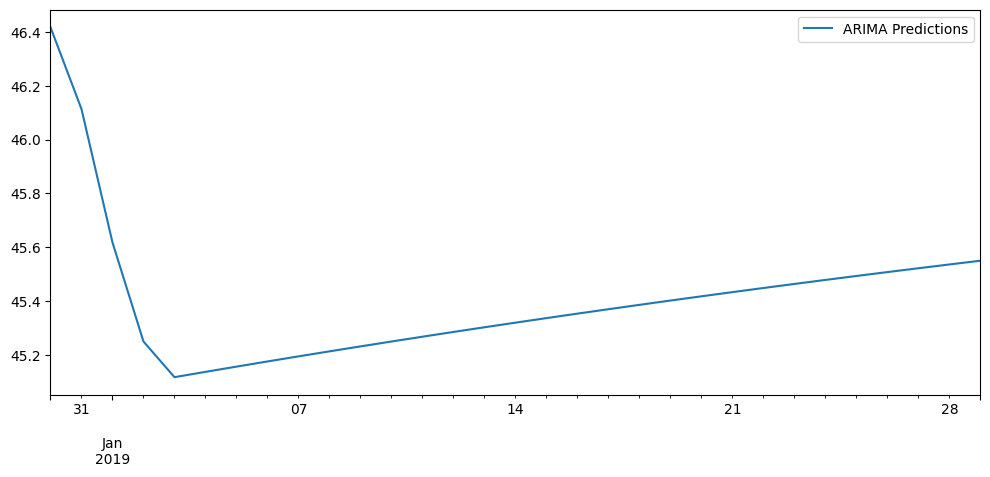

In [22]:
pred.plot(figsize=(12,5),legend=True)
